In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from midiutil import MIDIFile
from pprint import pprint

from utils import *

import random

In [ ]:
## Constraints
# 1. # of pianists, 2 hands, 5 fingers
# 2. time apart
# 3. spatial apart (in each hand cannot exceed one octave)
# 4. within one octave > same intensity > notes start at the same time > last for same period > not adjacent

In [2]:
## Parameters
group_num = 21 * 2 #21 pianists, 2 hands each
max_note_per_group = 5 #5 fingers

#min_pitch_gap = not set
win_length = 50e-3
max_time_gap = 0.3
max_frame_gap = int(round(max_time_gap / win_length))

In [48]:
key_time = 50e-3*0.5
Fs = 48000

#keys = scipy.io.loadmat('MATLAB_data/31Jan_jc.mat')['key']
keys = scipy.io.loadmat('MATLAB_data/doing_tdy_88.mat')['key']
notes_list = scipy.io.loadmat('notes_88.mat')['notes']
freq_list = scipy.io.loadmat('freq_480.mat')['f_cropped']
#freq_list = scipy.io.loadmat('freq_441.mat')['f_cropped']
notes_list = notes_list.reshape(np.size(notes_list))
freq_list = freq_list.reshape(np.size(freq_list))

note_num = 88

def get_intensity(cur_key,cur_freq,wave_freq):
    if cur_key == 1:
        sigma = notes_list[1]-notes_list[0]
    else:
        sigma = notes_list[cur_key-1]-notes_list[cur_key-2]
    sigma = sigma/2
    intensity = np.exp(-0.5 *((cur_freq-wave_freq)/sigma)**2)
    #print('cur', cur_freq,'wave',wave_freq)
    return intensity

def intensity2sign(intensity):
    if intensity < 0.67:
        return 'p'
    elif intensity < 0.77:
        return 'mp'
    elif intensity < 0.89:
        return 'mf'
    else:
        return 'f'

def picknotes(cur_key,cur_freq):
    j = 0
    while j < len(cur_key):
        if cur_key[j] != 0:
            if cur_key[j] > 88:
                pitch = cur_key[j] - 12
            else:
                pitch = cur_key[j]
            start = j
            while cur_key[j] != 0 and j < len(cur_key)-1:
                j += 1
            intensity = get_intensity(cur_key[j-1],cur_freq,notes_list[cur_key[j-1]-1])
            intensity_sign = intensity2sign(intensity)
            notes.append(Note(pitch, start, j - 1, intensity_sign, intensity))
        j += 1

notes = []
for i in range(np.shape(keys)[0]):
    cur_key = keys[i]
    cur_freq = freq_list[i]
    picknotes(cur_key,cur_freq)

notes = sorted(notes, key = lambda note: note.start)

def remove_repetitive(notes):
    note_set = [0]*note_num
    i = 0
    while i < len(notes):
        note = notes[i]
        if note_set[note.pitch-1] == 0:
            note_set[note.pitch-1] = [(note.start,note.end)]
        else:
            if (note.start,note.end) in note_set[note.pitch-1]:
                del notes[i]
                i -= 1
            else:
                note_set[note.pitch-1].append((note.start,note.end))
        i += 1
    return notes

new_notes = remove_repetitive(notes)
#pprint(new_notes)

In [49]:
print(len(new_notes))
len_notes = len(new_notes)
C_notes, Gb_notes = separate_majors(new_notes)
print(len(C_notes))
print(len(Gb_notes))
group_num2 = [round(21*len(C_notes)/len_notes) * 2, 42 - round(21*len(C_notes)/len_notes) * 2]
print(group_num2)

1099
535
564
[20, 22]


In [59]:
#for testing
new_notes = sorted(C_notes, key = lambda note: note.start)
group_num = group_num2[0]+2

In [4]:
word_gap = 15
def separate_word(notes):
    word_list = []
    ptr = 0
    for i in range(len(notes)-1):
        if notes[i+1].start - notes[i].end >= word_gap:
            word_list.append(notes[ptr:i+1])
            ptr = i + 1
        if i == len(notes) - 2:
            word_list.append(notes[ptr:])
    return word_list
    

In [5]:
def valid_note_to_allocate(note,overlapped,pitch_group,high):
    if (note.pitch not in pitch_group) and (note.pitch-min(pitch_group) <= 12):
        if overlapped and note.pitch < (high + 1):
            return False
        return True
    return False

def valid_to_add(counter,candidate,current_group,pitch_group):
    c1 = counter < len(candidate)
    c2 = len(current_group) < 5
    c3 = (candidate[counter][1].pitch not in pitch_group) if c1 else False
    return all([c1,c2,c3])

In [6]:
def allocation(notes_group):
    allocated_notes=[]
    group = 1
    overlapped = False #true if last group was left hand, current group is right hand, they should not overlap
    while notes_group != [] and group <= group_num:
        ## each while iteration allocate one group
        high = 0
        current_group = []
        if not overlapped:
            pitch_group = [notes_group[0].pitch]
            current_group.append(notes_group.pop(0))
        else:
            for i in range(len(notes_group)):
                if notes_group[i].pitch > (high + 1):
                    pitch_group = [notes_group[i].pitch]
                    current_group.append(notes_group.pop(i))
                    break
        for current_allocated_note in current_group:
            candidate = []
            # counter = 0
            for note in notes_group:
                if not valid_note_to_allocate(note,overlapped,pitch_group,high):
                    continue
                if note.intensity_sign == current_allocated_note.intensity_sign:
                    if note.start == current_allocated_note.start and note.end == current_allocated_note.end:
                        candidate.append([1,note])
                        # counter += 1
                    else:
                        candidate.append([2,note])
                elif note.start == current_allocated_note.start and note.end == current_allocated_note.end:
                    candidate.append([3,note])
                #     counter += 1
                # elif counter == 4:
                #     continue
                else:    
                    candidate.append([4,note])
            candidate.sort(key = lambda x: x[0])
            counter = 0
            while valid_to_add(counter,candidate,current_group,pitch_group) and (candidate[counter][0] == 1 or candidate[counter][1] == 2):
                pitch_group.append(candidate[counter][1].pitch)
                current_group.append(candidate[counter][1])
                notes_group.remove(candidate[counter][1])
                counter += 1
        #pprint(candidate)
        while valid_to_add(counter,candidate,current_group,pitch_group):
            pitch_group.append(candidate[counter][1].pitch)
            current_group.append(candidate[counter][1])
            notes_group.remove(candidate[counter][1])
            counter += 1
        # candidate.sort(key = lambda x: x[0])
        # counter = 0
        # while len(current_group) < 5 and counter < len(candidate):
        #     if candidate[counter][1].pitch not in pitch_group:
        #         pitch_group.append(candidate[counter][1].pitch)
        #         current_group.append(candidate[counter][1])
        #         notes_group.remove(candidate[counter][1])
        #     counter += 1
                                
        if not overlapped:
            for note in current_group:
                high = max(high,note.pitch)

        allocated_notes.append(current_group)

        overlapped = not overlapped
        group += 1 #finish allocate notes to one group, update
    
    if notes_group != []:
        print('Failed to allocate :(')
        print(len(notes_group))
        return False
    else:
        return allocated_notes

In [ ]:
if separate:
    ### TOBE FINISHED
    notes_groups = separate_majors(notes)
    result = []
    # for group in notes_groups:
    #     word_groups = separate_word(group)
    #     r = allocation(group)
    #     if not r:
    #         result.append(r)
    #     else:
    #         break
else:
    new_notes = sorted(new_notes, key = lambda notes: notes["start"])
    word_groups = separate_word(new_notes)
    #result = allocation(notes)

In [ ]:
adjacent_note_gap = 0

In [ ]:
## visualization tool
def plot_notes(note_list):
    time =[]
    pitch = []
    for note in note_list:
        time.append(note.start)
        pitch.append(note.pitch)
    plt.scatter(time,pitch,s=1)

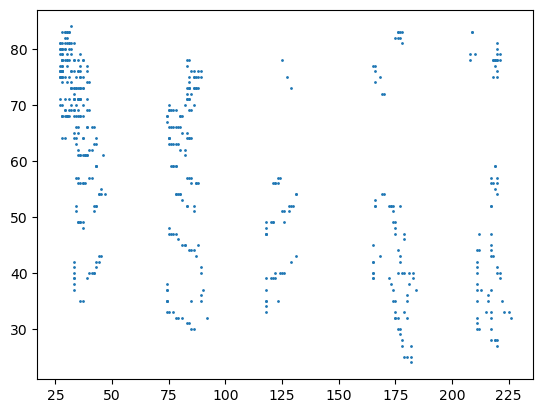

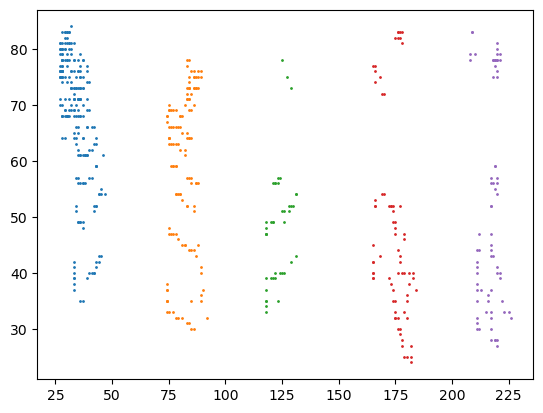

In [53]:
plot_notes(new_notes)
plt.show()
word_groups = separate_word(new_notes)
for g in word_groups:
    plot_notes(g)
plt.show()

In [54]:
for item in word_groups:
    print(len(item))

221
127
42
74
71


In [ ]:
for node in word_groups[0]:
    print(node)
print(len(word_groups[0]))

In [60]:
word_groups = separate_word(new_notes)
test_group = word_groups[3].copy()
result = False
while not result:
    result = allocation(test_group)
    test_group = word_groups[3].copy()
    random.shuffle(test_group)

Failed to allocate :(
7
Failed to allocate :(
4
Failed to allocate :(
2
Failed to allocate :(
11
Failed to allocate :(
7
Failed to allocate :(
2
Failed to allocate :(
3
Failed to allocate :(
4
Failed to allocate :(
7
Failed to allocate :(
2
Failed to allocate :(
2
Failed to allocate :(
1
Failed to allocate :(
1
Failed to allocate :(
3
Failed to allocate :(
7
Failed to allocate :(
4
Failed to allocate :(
3
Failed to allocate :(
4
Failed to allocate :(
7
Failed to allocate :(
6
Failed to allocate :(
4
Failed to allocate :(
7
Failed to allocate :(
11
Failed to allocate :(
2
Failed to allocate :(
2
Failed to allocate :(
4
Failed to allocate :(
9
Failed to allocate :(
10


C:\Users\96326\AppData\Local\Temp\ipykernel_19032\1496678670.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  if (note.pitch not in pitch_group) and (note.pitch-min(pitch_group) <= 12):


In [57]:
print(len(result))
pprint(result)

20
[[pitch = 52(time = 166-166), intensity sign = f, intensity = 0.949, channel = -1,
  pitch = 54(time = 170-170), intensity sign = f, intensity = 0.999, channel = -1,
  pitch = 53(time = 166-169), intensity sign = mp, intensity = 0.744, channel = -1],
 [pitch = 32(time = 175-181), intensity sign = f, intensity = 0.941, channel = -1,
  pitch = 39(time = 165-168), intensity sign = f, intensity = 0.953, channel = -1,
  pitch = 40(time = 178-179), intensity sign = f, intensity = 1.000, channel = -1,
  pitch = 38(time = 173-177), intensity sign = f, intensity = 0.919, channel = -1,
  pitch = 42(time = 165-173), intensity sign = f, intensity = 0.892, channel = -1],
 [pitch = 36(time = 180-185), intensity sign = mf, intensity = 0.822, channel = -1,
  pitch = 37(time = 184-184), intensity sign = mf, intensity = 0.811, channel = -1,
  pitch = 40(time = 165-174), intensity sign = mf, intensity = 0.809, channel = -1,
  pitch = 39(time = 172-176), intensity sign = mf, intensity = 0.807, channel 

In [61]:
word_groups = separate_word(new_notes)
final_allocation = [[],[]]
for i in range(2,5):
    print(i)
    current_allocate_group = word_groups[i].copy()
    result = False
    while not result:
        result = allocation(current_allocate_group)
        current_allocate_group = word_groups[i].copy()
        random.shuffle(current_allocate_group)
    
    final_allocation[0].extend(result[0])
    final_allocation[1].extend(result[1])
    pprint(final_allocation)
    print('success')

    

2
[[pitch = 35(time = 118-123), intensity sign = f, intensity = 0.989, channel = -1,
  pitch = 47(time = 118-118), intensity sign = f, intensity = 0.997, channel = -1,
  pitch = 39(time = 121-131), intensity sign = f, intensity = 0.999, channel = -1,
  pitch = 40(time = 124-132), intensity sign = f, intensity = 0.947, channel = -1],
 [pitch = 47(time = 118-120), intensity sign = p, intensity = 0.595, channel = -1,
  pitch = 48(time = 118-122), intensity sign = p, intensity = 0.594, channel = -1,
  pitch = 49(time = 121-126), intensity sign = p, intensity = 0.663, channel = -1,
  pitch = 56(time = 123-124), intensity sign = p, intensity = 0.638, channel = -1,
  pitch = 57(time = 123-124), intensity sign = p, intensity = 0.617, channel = -1]]
success
3
Failed to allocate :(
7
Failed to allocate :(
2
Failed to allocate :(
8
Failed to allocate :(
5
Failed to allocate :(
3
[[pitch = 35(time = 118-123), intensity sign = f, intensity = 0.989, channel = -1,
  pitch = 47(time = 118-118), intens

C:\Users\96326\AppData\Local\Temp\ipykernel_19032\1496678670.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  if (note.pitch not in pitch_group) and (note.pitch-min(pitch_group) <= 12):


Failed to allocate :(
5
Failed to allocate :(
9
Failed to allocate :(
1
Failed to allocate :(
16
Failed to allocate :(
7
Failed to allocate :(
1
Failed to allocate :(
11
Failed to allocate :(
4
Failed to allocate :(
4
Failed to allocate :(
12
Failed to allocate :(
10
Failed to allocate :(
3
Failed to allocate :(
12
Failed to allocate :(
7
Failed to allocate :(
2
Failed to allocate :(
13
Failed to allocate :(
6
Failed to allocate :(
4
Failed to allocate :(
8
Failed to allocate :(
3
Failed to allocate :(
7
Failed to allocate :(
13
Failed to allocate :(
11
Failed to allocate :(
7
Failed to allocate :(
5
Failed to allocate :(
8
Failed to allocate :(
7
Failed to allocate :(
5
Failed to allocate :(
5
Failed to allocate :(
7
Failed to allocate :(
6
Failed to allocate :(
3
Failed to allocate :(
3
Failed to allocate :(
7
Failed to allocate :(
8
Failed to allocate :(
6
Failed to allocate :(
14
Failed to allocate :(
4
Failed to allocate :(
2
Failed to allocate :(
3
Failed to allocate :(
13
Failed

In [62]:
print(final_allocation)

[[pitch = 35(time = 118-123), intensity sign = f, intensity = 0.989, channel = -1, pitch = 47(time = 118-118), intensity sign = f, intensity = 0.997, channel = -1, pitch = 39(time = 121-131), intensity sign = f, intensity = 0.999, channel = -1, pitch = 40(time = 124-132), intensity sign = f, intensity = 0.947, channel = -1, pitch = 82(time = 175-175), intensity sign = f, intensity = 0.929, channel = -1, pitch = 83(time = 176-178), intensity sign = f, intensity = 0.913, channel = -1, pitch = 35(time = 211-213), intensity sign = mp, intensity = 0.768, channel = -1, pitch = 41(time = 220-221), intensity sign = mp, intensity = 0.744, channel = -1, pitch = 44(time = 217-219), intensity sign = mp, intensity = 0.686, channel = -1], [pitch = 47(time = 118-120), intensity sign = p, intensity = 0.595, channel = -1, pitch = 48(time = 118-122), intensity sign = p, intensity = 0.594, channel = -1, pitch = 49(time = 121-126), intensity sign = p, intensity = 0.663, channel = -1, pitch = 56(time = 123

In [63]:
mf = MIDIFile(2)     # only 1 track
#track = 0   # the only track
time = 0    # start at the beginning
mf.addTrackName(0, time, "Right")
mf.addTrackName(1, time, "Left")
mf.addTempo(0, time, 1200)
mf.addTempo(1, time, 1200)

In [74]:
for i in range(2):    
    for note in final_allocation[1-i]:
        print(type(int(50+note.sign()*12.5)))
        mf.addNote(i,i,note.pitch+20, note.start, note.end-note.start+1,int(50+note.sign()*12.5))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [72]:
with open("midifile/allocation_test_C_major_20.mid", 'wb') as outf:
   mf.writeFile(outf)

error: required argument is not an integer

In [ ]:
l = 0
for i in result:
    l += len(i)
    print(i)
print(l == len(word_groups[4]))

In [ ]:
        # candidate = []
        # for i,note in enumerate(notes_group):
        #     if (note['note'] not in pitch_group) and (note['note']-pitch_group[0] <= 12):
        #         if overlapped and note['note'] > (high + 1):
        #             candidate.append(note)
        #         elif not overlapped:
        #             candidate.append(note)
        # for c in candidate:
        #     print(c)
        # for j,note in enumerate(candidate):
        #     if len(current_group) == 5:
        #         break
        #     for current_allocated_note in current_group:
        #         if note['start'] == current_allocated_note['start'] and note['end'] == current_allocated_note['end']:
        #             current_group.append(candidate.pop(j))
        #             notes_group.remove(note)
            
        # for j,note in enumerate(candidate):
        #     if len(current_group) == 5:
        #         break
        #     for current_allocated_note in current_group:
        #         if note['start'] == current_allocated_note['start']:
        #             current_group.append(candidate.pop(j))
        #             notes_group.remove(note)
            
        # for j,note in enumerate(candidate):
        #     if len(current_group) == 5:
        #         break
        #     for current_allocated_note in current_group:
        #         if note['end'] == current_allocated_note['end']:
        #             current_group.append(candidate.pop(j))
        #             notes_group.remove(note)

        # if len(current_group) != 5:
        #     for k in range(5-len(current_group)):
        #         current_group.append(candidate.pop(k))
        #         notes_group.remove(candidate[k])

In [70]:
print(int(1.5))

1
